# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [93]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')

<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [94]:
data = pd.read_csv(r'../input/donorschoosewithglovevectors/preprocessed_data.csv')

In [95]:
data.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [96]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
y=data['project_is_approved'].values
x=data.drop(['project_is_approved'],axis=1)
x.head(1)


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


In [97]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42,stratify=y)

In [98]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(73196, 8)
(73196,)
(36052, 8)
(36052,)


<h2>1.3 Make Data Model Ready: encoding essay, and project_title</h2>

### Encoding Essay with TF-IDF

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer

TFIDF = TfidfVectorizer(min_df=10,ngram_range=(1,1),stop_words='english')
TFIDF.fit(x_train['essay'].values)

x_train_tfidf = TFIDF.transform(x_train['essay'].values)
x_test_tfidf = TFIDF.transform(x_test['essay'].values)

In [100]:
print(x_train_tfidf.shape, y_train.shape)
print(x_test_tfidf.shape,y_test.shape)

(73196, 13985) (73196,)
(36052, 13985) (36052,)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

### Encoding Numerical Features

In [101]:
from sklearn.preprocessing import Normalizer

#price
normalizer = Normalizer()
normalizer.fit(x_train['price'].values.reshape(1,-1))

x_train_price_normalized = normalizer.transform(x_train['price'].values.reshape(1,-1)).reshape(-1,1)
x_test_price_normalized = normalizer.transform(x_test['price'].values.reshape(1,-1)).reshape(-1,1)

print(x_train_price_normalized.shape)
print(x_test_price_normalized.shape)

#teacher_number_of_previously_posted_projects
normalizer.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

x_train_teacher_number_of_previously_posted_projects_normalized = normalizer.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).reshape(-1,1)
x_test_teacher_number_of_previously_posted_projects_normalized = normalizer.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).reshape(-1,1)

print(x_train_teacher_number_of_previously_posted_projects_normalized.shape)
print(x_test_teacher_number_of_previously_posted_projects_normalized.shape)

(73196, 1)
(36052, 1)
(73196, 1)
(36052, 1)


### Encoding Categorical Features

In [102]:
x_train.insert(loc=len(x_train.columns),column='y_dummy',value=y_train)

In [103]:
x_test.insert(loc=len(x_test.columns),column='y_dummy',value=y_test)

In [104]:
def calculate_prob_score(xtrain,feature):
    positive_prob_score={}
    negative_prob_score={}
    unique_values = xtrain[feature].unique()
    for value in unique_values:
        positive_count = len(xtrain.loc[(xtrain[feature]==value) & (xtrain['y_dummy']==1)])
        negative_count = len(xtrain.loc[(xtrain[feature]==value) & (xtrain['y_dummy']==0)])
        positive_prob_score[value]=(positive_count/(positive_count+negative_count))
        negative_prob_score[value]=(negative_count/(positive_count+negative_count))
    return positive_prob_score, negative_prob_score

def response_coding(xtrain,xtest,feature):
    no_of_values = x_train['y_dummy'].nunique()
    for i in range(0,no_of_values):
        index = x_train.columns.get_loc(feature)
        x_train.insert(loc=index,column=feature+'_'+str(i),value=x_train[feature]) #creating two columns for each categorical features as _0 and _1
        x_test.insert(loc=index,column=feature+'_'+str(i),value=x_test[feature])
    positive,negative = calculate_prob_score(xtrain,feature)
    unique_test_values = x_test[feature].unique()
    for value in unique_test_values:
        if value not in positive:
            positive[value]=0.5
            negative[value]=0.5
    
    for key,value in positive.items():
        x_train[feature+'_'+str(i)] = np.where((x_train[feature]==key),value,x_train[feature+'_'+str(i)])
        x_test[feature+'_'+str(i)] = np.where((x_test[feature]==key),value,x_test[feature+'_'+str(i)])
    arr1 = x_train[feature+'_'+str(i)].values
    arr2 = x_test[feature+'_'+str(i)].values
    i=i-1
    for key,value in negative.items():
        x_train[feature+'_'+str(i)] = np.where((x_train[feature]==key),value,x_train[feature+'_'+str(i)])
        x_test[feature+'_'+str(i)] = np.where((x_test[feature]==key),value,x_test[feature+'_'+str(i)])
    arr3 = x_train[feature+'_'+str(i)].values
    arr4 = x_test[feature+'_'+str(i)].values
        
    return arr1,arr2,arr3,arr4
            
        
    
    
    
    
    

In [105]:
#school_state
xtrain_school_state_0, xtest_school_state_0, xtrain_school_state_1, xtest_school_state_1 = response_coding(x_train,x_test,'school_state')
xtrain_school_state_0 = xtrain_school_state_0.reshape(-1,1).astype(float)
xtrain_school_state_1 = xtrain_school_state_1.reshape(-1,1).astype(float)
xtest_school_state_0 = xtest_school_state_0.reshape(-1,1).astype(float)
xtest_school_state_1 = xtest_school_state_1.reshape(-1,1).astype(float)

In [106]:
#teacher_prefix
xtrain_teacher_prefix_0, xtest_teacher_prefix_0, xtrain_teacher_prefix_1, xtest_teacher_prefix_1 = response_coding(x_train,x_test,'teacher_prefix')
xtrain_teacher_prefix_0 = xtrain_teacher_prefix_0.reshape(-1,1).astype(float)
xtrain_teacher_prefix_1 = xtrain_teacher_prefix_1.reshape(-1,1).astype(float)
xtest_teacher_prefix_0 = xtest_teacher_prefix_0.reshape(-1,1).astype(float)
xtest_teacher_prefix_1 = xtest_teacher_prefix_1.reshape(-1,1).astype(float)

In [107]:
#project_grade_category
xtrain_project_grade_category_0, xtest_project_grade_category_0, xtrain_project_grade_category_1, xtest_project_grade_category_1 = response_coding(x_train,x_test,'project_grade_category')
xtrain_project_grade_category_0 = xtrain_project_grade_category_0.reshape(-1,1).astype(float)
xtrain_project_grade_category_1 = xtrain_project_grade_category_1.reshape(-1,1).astype(float)
xtest_project_grade_category_0 = xtest_project_grade_category_0.reshape(-1,1).astype(float)
xtest_project_grade_category_1 = xtest_project_grade_category_1.reshape(-1,1).astype(float)

In [108]:
#clean_categories
xtrain_clean_categories_0, xtest_clean_categories_0, xtrain_clean_categories_1, xtest_clean_categories_1 = response_coding(x_train,x_test,'clean_categories')
xtrain_clean_categories_0 = xtrain_clean_categories_0.reshape(-1,1).astype(float)
xtrain_clean_categories_1 = xtrain_clean_categories_1.reshape(-1,1).astype(float)
xtest_clean_categories_0 = xtest_clean_categories_0.reshape(-1,1).astype(float)
xtest_clean_categories_1 = xtest_clean_categories_1.reshape(-1,1).astype(float)

In [109]:
#clean_subcategories
xtrain_clean_subcategories_0, xtest_clean_subcategories_0, xtrain_clean_subcategories_1, xtest_clean_subcategories_1 = response_coding(x_train,x_test,'clean_subcategories')
xtrain_clean_subcategories_0 = xtrain_clean_subcategories_0.reshape(-1,1).astype(float)
xtrain_clean_subcategories_1 = xtrain_clean_subcategories_1.reshape(-1,1).astype(float)
xtest_clean_subcategories_0 = xtest_clean_subcategories_0.reshape(-1,1).astype(float)
xtest_clean_subcategories_1 = xtest_clean_subcategories_1.reshape(-1,1).astype(float)

array([[0.00161251],
       [0.00049616],
       [0.        ],
       ...,
       [0.00012404],
       [0.00012404],
       [0.        ]])

## 1.5 Taking sentiment values of essay from sentimentAnalyzer()

In [110]:
x_train_essay = x_train['essay'].values
x_test_essay = x_test['essay'].values

In [111]:
print(x_train_essay.shape,x_test_essay.shape)

(73196,) (36052,)


In [112]:
x_train_essay[0]

'our school title i elementary school located socio economically disadvantaged area city we diverse group largest student population primarily african american 90 receive free reduced lunch we avid school want students become life long learners college bond my students amazing they young fun ready learn the students classroom love learn thirst knowledge curiosity world having chromebooks room allow students access self paced learning curriculum allowing successful learning hands approach we limited technology building computers i classroom pulled state assessments weeks time leaving students no computers classroom we avid school chromebooks classroom help become college career ready 21st technology skills chromebooks used literacy math centers students develop skills class regular basis helping remain class within class setting this provide highly engaging necessary tool academic skills nannan'

In [113]:
sid = SentimentIntensityAnalyzer()
for_sentiment = x_train_essay[0]
ss=sid.polarity_scores(for_sentiment)
print(ss['neg'])

0.045


In [114]:
# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
neg_train=[]
neu_train=[]
pos_train=[]
compound_train=[]

neg_test=[]
neu_test=[]
pos_test=[]
compound_test=[]

for description in tqdm(x_train_essay):
    for_sentiment = description
    ss = sid.polarity_scores(for_sentiment)
    neg_train.append(ss['neg'])
    neu_train.append(ss['neu'])
    pos_train.append(ss['pos'])
    compound_train.append(ss['compound'])
    
for description in tqdm(x_test_essay):
    for_sentiment = description
    ss = sid.polarity_scores(for_sentiment)
    neg_test.append(ss['neg'])
    neu_test.append(ss['neu'])
    pos_test.append(ss['pos'])
    compound_test.append(ss['compound'])



# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

100%|██████████| 36052/36052 [01:26<00:00, 417.54it/s]


In [115]:
#reshaping train sentiment values
neg_train_sentiment = np.array(neg_train).reshape(-1,1).astype('float')
neu_train_sentiment = np.array(neu_train).reshape(-1,1).astype('float')
pos_train_sentiment = np.array(pos_train).reshape(-1,1).astype('float')
compound_train_sentiment = np.array(compound_train).reshape(-1,1).astype('float')

#reshaping test sentiment values
neg_test_sentiment = np.array(neg_test).reshape(-1,1).astype('float')
neu_test_sentiment = np.array(neu_test).reshape(-1,1).astype('float')
pos_test_sentiment = np.array(pos_test).reshape(-1,1).astype('float')
compound_test_sentiment = np.array(compound_test).reshape(-1,1).astype('float')  

## 1.6 Creating total dataset with tf-idf values and converted values

In [116]:
x_train.head(1)

,school_state_0,school_state_1,school_state,teacher_prefix_0,teacher_prefix_1,teacher_prefix,project_grade_category_0,project_grade_category_1,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories_0,clean_categories_1,clean_categories,clean_subcategories_0,clean_subcategories_1,clean_subcategories,essay,price,y_dummy
76564,0.143868,0.856132,ks,0.1454,0.8546,mrs,0.151673,0.848327,grades_prek_2,13,0.128103,0.871897,literacy_language math_science,0.123903,0.876097,literacy mathematics,our school title i elementary school located s...,742.2,1


In [117]:
x_train['price']=x_train_price_normalized
x_train['teacher_number_of_previously_posted_projects']=x_train_teacher_number_of_previously_posted_projects_normalized

In [118]:
from scipy.sparse import hstack

X_Train = hstack((x_train_tfidf,
                  xtrain_school_state_0,
                  xtrain_school_state_1,
                  xtrain_teacher_prefix_0,
                  xtrain_teacher_prefix_1,
                  xtrain_project_grade_category_0,
                  xtrain_project_grade_category_1,
                  xtrain_clean_categories_0,
                  xtrain_clean_categories_1,
                  xtrain_clean_subcategories_0,
                  xtrain_clean_subcategories_1,
                  x_train_price_normalized,
                  x_train_teacher_number_of_previously_posted_projects_normalized,
                  neg_train_sentiment,
                  neu_train_sentiment,
                  pos_train_sentiment,
                  compound_train_sentiment)).tocsr()

X_Test = hstack((x_test_tfidf,
                  xtest_school_state_0,
                  xtest_school_state_1,
                  xtest_teacher_prefix_0,
                  xtest_teacher_prefix_1,
                  xtest_project_grade_category_0,
                  xtest_project_grade_category_1,
                  xtest_clean_categories_0,
                  xtest_clean_categories_1,
                  xtest_clean_subcategories_0,
                  xtest_clean_subcategories_1,
                  x_test_price_normalized,
                  x_test_teacher_number_of_previously_posted_projects_normalized,
                  neg_test_sentiment,
                  neu_test_sentiment,
                  pos_test_sentiment,
                  compound_test_sentiment)).tocsr()

In [119]:
print(X_Train.shape,y_train.shape)

(73196, 14001) (73196,)


In [120]:
print(X_Test.shape,y_test.shape)

(36052, 14001) (36052,)


<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

In [121]:
#feature set 1
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve, GridSearchCV


    

lgb = LGBMClassifier(class_weight='balanced', n_jobs=-1)
parameters = {'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'n_estimators': [5,10,50, 75, 100]}
clf=GridSearchCV(lgb, parameters, cv=3, scoring='roc_auc', verbose = 1,n_jobs=-1, return_train_score=True)
clf.fit(X_Train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 23.1min finished


GridSearchCV(cv=3, estimator=LGBMClassifier(class_weight='balanced'), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
                         'n_estimators': [5, 10, 50, 75, 100]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [122]:
clf.cv_results_

{'mean_fit_time': array([31.49472706, 35.51734122, 62.91791582, 81.34962781, 97.99702438,
        31.26217413, 34.70084953, 64.38943442, 81.24695683, 98.68224136,
        31.14912279, 34.600945  , 63.00851838, 80.64237309, 96.7752858 ,
        31.21366278, 34.78375697, 62.02573816, 78.30426367, 92.71827141,
        31.07651464, 35.41402054, 62.33488067, 75.30314   , 88.41760055,
        32.04503123, 35.99542721, 60.97578406, 72.76324487, 71.6980838 ]),
 'std_fit_time': array([ 0.38536574,  0.24428837,  0.49751653,  0.93254469,  0.52108269,
         0.19120069,  0.38140135,  0.52850363,  0.67983967,  0.96407813,
         0.41969185,  0.30008321,  0.40169958,  0.60220644,  0.61192403,
         0.32014768,  0.63039351,  0.53012353,  0.02393099,  0.271516  ,
         0.44311018,  0.66673047,  0.19387484,  0.83497976,  1.70042735,
         0.26685123,  0.5802893 ,  0.48280306,  0.7616759 , 10.13258237]),
 'mean_score_time': array([0.08122595, 0.06375567, 0.11568292, 0.14975444, 0.17488456,


In [123]:
df_clf = pd.DataFrame(clf.cv_results_)
df_clf.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,31.494727,0.385366,0.081226,0.020973,0.0001,5,"{'learning_rate': 0.0001, 'n_estimators': 5}",0.651058,0.658315,0.656786,0.655386,0.003124,30,0.671725,0.677379,0.676982,0.675362,0.002577
1,35.517341,0.244288,0.063756,0.002143,0.0001,10,"{'learning_rate': 0.0001, 'n_estimators': 10}",0.651861,0.658315,0.656786,0.655654,0.002754,29,0.672207,0.677379,0.676982,0.675522,0.002350
2,62.917916,0.497517,0.115683,0.005050,0.0001,50,"{'learning_rate': 0.0001, 'n_estimators': 50}",0.652539,0.661153,0.658477,0.657390,0.003600,27,0.672817,0.680268,0.679300,0.677461,0.003308
3,81.349628,0.932545,0.149754,0.001492,0.0001,75,"{'learning_rate': 0.0001, 'n_estimators': 75}",0.653049,0.662069,0.658513,0.657877,0.003709,25,0.673176,0.681189,0.681049,0.678471,0.003745
4,97.997024,0.521083,0.174885,0.007621,0.0001,100,"{'learning_rate': 0.0001, 'n_estimators': 100}",0.653175,0.661996,0.658544,0.657905,0.003629,24,0.673408,0.681447,0.682043,0.678966,0.003938


In [124]:
scores_clf = df_clf.groupby(['param_learning_rate','param_n_estimators']).max().unstack()[['mean_train_score','mean_test_score']]

In [125]:
scores_clf

mean_train_score                                          \
param_n_estimators               5         10        50        75        100   
param_learning_rate                                                            
0.0001                      0.675362  0.675522  0.677461  0.678471  0.678966   
0.0010                      0.676384  0.678704  0.687721  0.690902  0.693380   
0.0100                      0.688214  0.693998  0.718495  0.728489  0.737599   
0.1000                      0.714416  0.733866  0.823795  0.856548  0.881014   
0.2000                      0.726631  0.757816  0.872958  0.909548  0.935231   
0.3000                      0.737875  0.774985  0.901566  0.937163  0.960001   

                    mean_test_score                                          
param_n_estimators              5         10        50        75        100  
param_learning_rate                                                          
0.0001                     0.655386  0.655654  0.657390  0.657877  0.657905  
0.0010                     0.656526  0.657846  0.663759  0.666041  0.668036  
0.0100                     0.664746  0.669089  0.688564  0.695389  0.701128  
0.1000                     0.685871  0.696973  0.731516  0.734892  0.736164  
0.2000                     0.692344  0.709058  0.730756  0.729732  0.727843  
0.3000                     0.695609  0.713130  0.721685  0.719078  0.715228

In [126]:
train_score_1 = scores_clf['mean_train_score']
test_score_1 = scores_clf['mean_test_score']


Text(0.5, 1.0, 'CV Score - Feature Set 1')

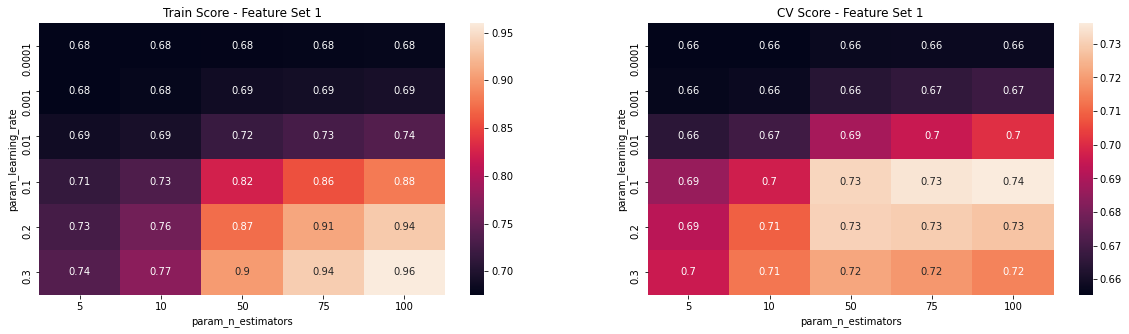

In [127]:
import seaborn as sns
fig,ax = plt.subplots(ncols=2,figsize=(20,5))
sns.heatmap(train_score_1,annot=True,ax=ax[0])
sns.heatmap(test_score_1,annot=True,ax=ax[1])
ax[0].set_title("Train Score - Feature Set 1")
ax[1].set_title("CV Score - Feature Set 1")

In [128]:
clf.best_params_

{'learning_rate': 0.1, 'n_estimators': 100}

In [129]:
best_model_1 = clf.best_estimator_
best_model_1.fit(X_Train,y_train)
learning_rate_1 = clf.best_params_['learning_rate']
n_estimator_1 = clf.best_params_['n_estimators']

In [130]:
print(learning_rate_1,n_estimator_1)

0.1 100


In [131]:
y_pred_prob_train_1 = best_model_1.predict_proba(X_Train)
y_pred_prob_test_1 = best_model_1.predict_proba(X_Test)

In [132]:
y_pred_prob_train_1

array([[0.37732048, 0.62267952],
       [0.78931092, 0.21068908],
       [0.46393047, 0.53606953],
       ...,
       [0.32749983, 0.67250017],
       [0.46434529, 0.53565471],
       [0.30213778, 0.69786222]])

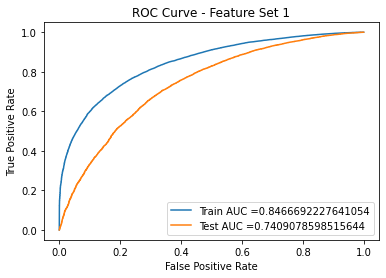

In [133]:
from sklearn.metrics import roc_curve,auc

train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_pred_prob_train_1[:,1])
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_pred_prob_test_1[:,1])
train_auc_1 = auc(train_fpr,train_tpr)
test_auc_1 = auc(test_fpr,test_tpr)
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(train_auc_1))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(test_auc_1))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Feature Set 1")
plt.legend()
plt.show()

In [134]:
from sklearn.metrics import confusion_matrix
y_pred_1 = best_model_1.predict(X_Test)
cm_1 = confusion_matrix(y_test,y_pred_1)
cm_1

array([[ 3648,  1811],
       [ 9265, 21328]])

Text(0.5, 1.0, 'Confusion Matrix - Feature Set 1')

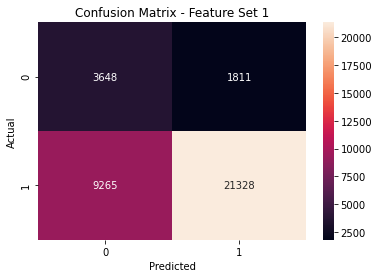

In [135]:
sns.heatmap(cm_1,annot=True,fmt="g")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Feature Set 1')

In [136]:
#feature set 2

#loading glove vectors
import pickle
with open('../input/donorschoosewithglovevectors/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [137]:
#tfidf w2v

tfidf_model = TfidfVectorizer()
tfidf_model.fit(x_train['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

x_train_essays_tfidf_w2v_vectors = []
for essay in tqdm(x_train['essay']): 
    vector = np.zeros(300) 
    tf_idf_weight =0
    for word in essay.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(essay.count(word)/len(essay.split())) 
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    x_train_essays_tfidf_w2v_vectors.append(vector)
    
x_test_essays_tfidf_w2v_vectors = []
for essay in tqdm(x_test['essay']):
    vector = np.zeros(300) 
    tf_idf_weight =0
    for word in essay.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(essay.count(word)/len(essay.split())) 
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    x_test_essays_tfidf_w2v_vectors.append(vector)

100%|██████████| 36052/36052 [01:43<00:00, 348.62it/s]


In [142]:
X_Train_1 = np.hstack((x_train_essays_tfidf_w2v_vectors,
                  xtrain_school_state_0,
                  xtrain_school_state_1,
                  xtrain_teacher_prefix_0,
                  xtrain_teacher_prefix_1,
                  xtrain_project_grade_category_0,
                  xtrain_project_grade_category_1,
                  xtrain_clean_categories_0,
                  xtrain_clean_categories_1,
                  xtrain_clean_subcategories_0,
                  xtrain_clean_subcategories_1,
                  x_train_price_normalized,
                  x_train_teacher_number_of_previously_posted_projects_normalized))

X_Test_1 = np.hstack((x_test_essays_tfidf_w2v_vectors,
                  xtest_school_state_0,
                  xtest_school_state_1,
                  xtest_teacher_prefix_0,
                  xtest_teacher_prefix_1,
                  xtest_project_grade_category_0,
                  xtest_project_grade_category_1,
                  xtest_clean_categories_0,
                  xtest_clean_categories_1,
                  xtest_clean_subcategories_0,
                  xtest_clean_subcategories_1,
                  x_test_price_normalized,
                  x_test_teacher_number_of_previously_posted_projects_normalized))

In [143]:
print(X_Train_1.shape,y_train.shape)
print(X_Test_1.shape,y_test.shape)

(73196, 312) (73196,)
(36052, 312) (36052,)


In [144]:
lgb = LGBMClassifier(class_weight='balanced', n_jobs=-1)
parameters = {'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'n_estimators': [5,10,50, 75, 100]}
clf_1=GridSearchCV(lgb, parameters, cv=3, scoring='roc_auc', verbose = 1,n_jobs=-1, return_train_score=True)
clf_1.fit(X_Train_1, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  6.8min finished


GridSearchCV(cv=3, estimator=LGBMClassifier(class_weight='balanced'), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
                         'n_estimators': [5, 10, 50, 75, 100]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [146]:
df_clf_1 = pd.DataFrame(clf_1.cv_results_)
df_clf_1.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,6.918662,0.028487,0.080974,0.002578,0.0001,5,"{'learning_rate': 0.0001, 'n_estimators': 5}",0.634356,0.633237,0.633729,0.633774,0.000458,29,0.667300,0.672636,0.669192,0.669709,0.002209
1,7.925557,0.218153,0.085687,0.001754,0.0001,10,"{'learning_rate': 0.0001, 'n_estimators': 10}",0.634356,0.633237,0.633729,0.633774,0.000458,29,0.667300,0.672636,0.669192,0.669709,0.002209
2,19.393532,0.439579,0.145654,0.005544,0.0001,50,"{'learning_rate': 0.0001, 'n_estimators': 50}",0.639657,0.633237,0.635937,0.636277,0.002632,27,0.671942,0.672636,0.671735,0.672104,0.000385
3,25.388169,0.425673,0.160092,0.000747,0.0001,75,"{'learning_rate': 0.0001, 'n_estimators': 75}",0.642904,0.633237,0.636499,0.637547,0.004015,26,0.675087,0.672636,0.672729,0.673484,0.001134
4,32.175142,0.427131,0.192213,0.006035,0.0001,100,"{'learning_rate': 0.0001, 'n_estimators': 100}",0.647642,0.633237,0.636463,0.639114,0.006172,24,0.681027,0.672636,0.673822,0.675828,0.003708


In [147]:
scores_clf_1 = df_clf_1.groupby(['param_learning_rate','param_n_estimators']).max().unstack()[['mean_train_score','mean_test_score']]

In [148]:
scores_clf_1

mean_train_score                                          \
param_n_estimators               5         10        50        75        100   
param_learning_rate                                                            
0.0001                      0.669709  0.669709  0.672104  0.673484  0.675828   
0.0010                      0.671981  0.675509  0.696093  0.701480  0.706275   
0.0100                      0.695838  0.705813  0.734404  0.744621  0.752708   
0.1000                      0.721062  0.744280  0.829126  0.865157  0.893657   
0.2000                      0.732199  0.762469  0.881112  0.922313  0.950231   
0.3000                      0.738821  0.774430  0.910547  0.949863  0.973074   

                    mean_test_score                                          
param_n_estimators              5         10        50        75        100  
param_learning_rate                                                          
0.0001                     0.633774  0.633774  0.636277  0.637547  0.639114  
0.0010                     0.636060  0.638965  0.655625  0.659808  0.663809  
0.0100                     0.655550  0.663579  0.684281  0.689774  0.694407  
0.1000                     0.675474  0.689417  0.712948  0.713665  0.713174  
0.2000                     0.676731  0.692617  0.705620  0.702157  0.699912  
0.3000                     0.681299  0.694250  0.693673  0.687842  0.684017

In [149]:
train_score_2 = scores_clf_1['mean_train_score']
test_score_2 = scores_clf_1['mean_test_score']

Text(0.5, 1.0, 'CV Score - Feature Set 2')

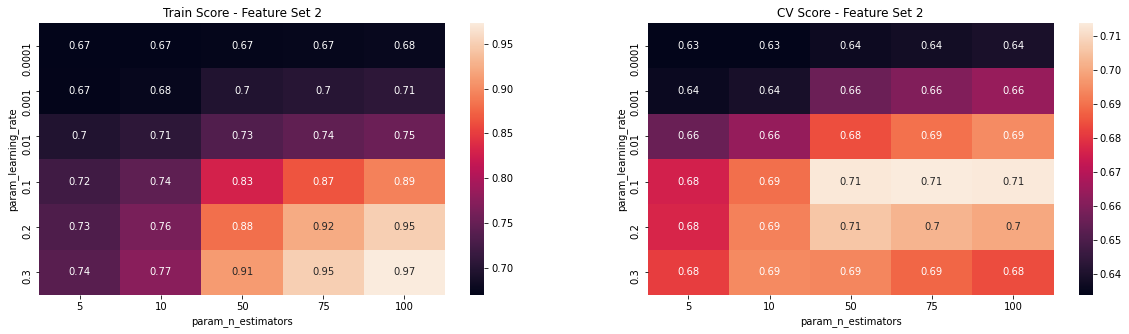

In [150]:
import seaborn as sns
fig,ax = plt.subplots(ncols=2,figsize=(20,5))
sns.heatmap(train_score_2,annot=True,ax=ax[0])
sns.heatmap(test_score_2,annot=True,ax=ax[1])
ax[0].set_title("Train Score - Feature Set 2")
ax[1].set_title("CV Score - Feature Set 2")

In [151]:
best_model_2 = clf_1.best_estimator_
best_model_2.fit(X_Train_1,y_train)
learning_rate_2 = clf.best_params_['learning_rate']
n_estimator_2 = clf.best_params_['n_estimators']

In [152]:
y_pred_prob_train_2 = best_model_2.predict_proba(X_Train_1)
y_pred_prob_test_2 = best_model_2.predict_proba(X_Test_1)

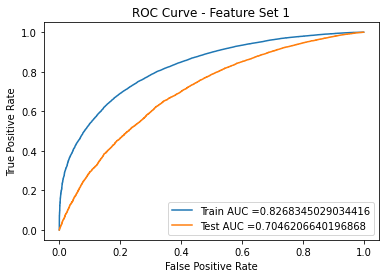

In [153]:
train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_pred_prob_train_2[:,1])
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_pred_prob_test_2[:,1])
train_auc_2 = auc(train_fpr,train_tpr)
test_auc_2 = auc(test_fpr,test_tpr)
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(train_auc_2))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(test_auc_2))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Feature Set 1")
plt.legend()
plt.show()

In [155]:
y_pred_2 = best_model_2.predict(X_Test_1)
cm_2 = confusion_matrix(y_test,y_pred_2)
cm_2

array([[ 3490,  1969],
       [10203, 20390]])

Text(0.5, 1.0, 'Confusion Matrix - Feature Set 2')

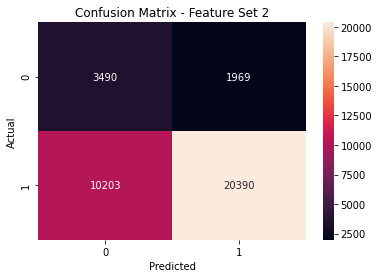

In [156]:
sns.heatmap(cm_2,annot=True,fmt="g")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Feature Set 2')

In [157]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [158]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer","Model","learning rate","n estimators","Train AUC","Test AUC"]

x.add_row(["TF-IDF","LightGBM", learning_rate_1,n_estimator_1,train_auc_1,test_auc_1])
x.add_row(["TF-IDF W2V","LightGBM", learning_rate_2,n_estimator_2,train_auc_2,test_auc_2])



print(x)

+------------+----------+---------------+--------------+--------------------+--------------------+
| Vectorizer |  Model   | learning rate | n estimators |     Train AUC      |      Test AUC      |
+------------+----------+---------------+--------------+--------------------+--------------------+
|   TF-IDF   | LightGBM |      0.1      |     100      | 0.8466692227641054 | 0.7409078598515644 |
| TF-IDF W2V | LightGBM |      0.1      |     100      | 0.8268345029034416 | 0.7046206640196868 |
+------------+----------+---------------+--------------+--------------------+--------------------+
